In [6]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter("ignore")
import time
import random
import sys
import importlib
import editdistance
import numpy as np
from prondict import *
from lab3_proto import *
from lab3_tools import *
from lab1_proto import *
from lab1_tools import *
from lab2_proto import *
from lab2_tools import *
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 4)
np.set_printoptions(precision=3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Target Class Definition

In [3]:
#phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
stateList.sort()
stateList = np.array(stateList)
print(stateList)
stateList[39]

['ah_0' 'ah_1' 'ah_2' 'ao_0' 'ao_1' 'ao_2' 'ay_0' 'ay_1' 'ay_2' 'eh_0'
 'eh_1' 'eh_2' 'ey_0' 'ey_1' 'ey_2' 'f_0' 'f_1' 'f_2' 'ih_0' 'ih_1' 'ih_2'
 'iy_0' 'iy_1' 'iy_2' 'k_0' 'k_1' 'k_2' 'n_0' 'n_1' 'n_2' 'ow_0' 'ow_1'
 'ow_2' 'r_0' 'r_1' 'r_2' 's_0' 's_1' 's_2' 'sil_0' 'sil_1' 'sil_2' 'sp_0'
 't_0' 't_1' 't_2' 'th_0' 'th_1' 'th_2' 'uw_0' 'uw_1' 'uw_2' 'v_0' 'v_1'
 'v_2' 'w_0' 'w_1' 'w_2' 'z_0' 'z_1' 'z_2']


'sil_0'

# load all the data

In [ ]:
example = np.load('lab3_example.npz', allow_pickle=True)['example'].item()
example.keys()

## create the word transcription

In [ ]:
phoneTrans =  words2phones(example['wordTrans'], prondict)
print(phoneTrans == example['phoneTrans'])
print(phoneTrans)

print("\n HMM concat")
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
print(utteranceHMM.keys())
for key in utteranceHMM.keys():
    print(key," is allclose?:", np.allclose(utteranceHMM[key], example['utteranceHMM'][key]))

print("\nstateTrans")
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
print(stateTrans == example['stateTrans'])
print(stateTrans)

print("\nstateList")
obsLogLik = log_multivariate_normal_density_diag(example['lmfcc'], utteranceHMM['means'], utteranceHMM['covars'])
print("obsloglik allclose? ", np.allclose(obsLogLik, example['obsloglik']))


alphas = forward(obsLogLik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']))
prob, path = viterbi(obsLogLik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']))
plt.pcolormesh(alphas.T)
plt.plot(np.arange(0.5, path.shape[0], 1), path+0.5, 'r')
plt.plot(np.arange(0.5, example['viterbiPath'].shape[0], 1), example['viterbiPath']+0.5, 'c')
plt.show()

print("viterbi loglik equal?", prob == example['viterbiLoglik'])
newPathText = [stateTrans[state] for state in path]
newPath = [stateList.index(stateTrans[state]) for state in path]
newPathtt = [stateTrans[state] for state in path]
#print(newPathtt)
#print(newPath)
#print(newPath)
#print("exapmole paht:", example['viterbiStateTrans'])
print("path equal to example?", newPathtt == example['viterbiStateTrans'])

print("generate path file")
frames2trans(newPathText, outfilename='z43a.lab')

In [ ]:
pathTranscripedDict = {}
for file in files:
    phonemes = list(path2info(filename)[2])
    paddedPhoneme = words2phones(phonemes, prondict)
    pathTranscripedDict[path] = paddedPhoneme

## create HMMs

In [ ]:
HMMs = {}
for path in pathTranscripedDict.keys():
    concatHMM = concatHMMs(phoneHMMs, pathTranscripedDict[path])
    concatHMM['stateTrans'] = stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
    
    HMMs[pathTranscripedDict[path]] = concatHMM

# alignment

In [ ]:
for hmm_name in HMMs.keys():
    #todo figure out how to deal with files
    datum = hmm['features']
    obsLogLik = log_multivariate_normal_density_diag(datum, HMMs[hmm_name]['means'], HMMs[hmm_name]['means']['covars'])
    
    prob, path = prob, path = viterbi(obsLogLik, np.log(HMMs[hmm_name]['startprob']), np.log(HMMs[hmm_name]['transmat']))
    
    #transform path to states
    newPath = [HMMs[hmm_name]['stateTrans'][state] for state in path]
    HMMs[hmm_name] = frames2trans(newPath, outputfilename = hmm_name + ".lab")
    


# create dataset

## traindata

In [ ]:
traindata = []
for root, dirs, files in os.walk('tidigits/disc_4.1.1/tidigits/train'):
    for file in files:
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            samples, samplingrate = loadAudio(filename)
            mspecArr = mspec(samples)
            lmfcc = mfcc(samples)
            wordTrans = list(path2info(filename)[2])
            phoneTrans =  words2phones(wordTrans, prondict)
            stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
            
            
            utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
            obsLogLik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
            prob, path = viterbi(obsLogLik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']))
            
            newPath = [stateList.index(stateTrans[state]) for state in path]
            newPath = np.array(newPath)
            print("lentraindata", len(traindata), " shape lmfcc", lmfcc.shape, " mspecshape", mspecArr.shape)
            traindata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspecArr, 'targets': newPath})
            
np.savez('traindata.npz', traindata=traindata)

## testdata

In [ ]:
testdata = []
for root, dirs, files in os.walk('tidigits/disc_4.2.1/tidigits/test'):
    for file in files:
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            samples, samplingrate = loadAudio(filename)
            mspecArr = mspec(samples)
            lmfcc = mfcc(samples)
            wordTrans = list(path2info(filename)[2])
            phoneTrans =  words2phones(wordTrans, prondict)
            stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
            
            
            utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
            obsLogLik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
            prob, path = viterbi(obsLogLik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']))
            
            newPath = [stateList.index(stateTrans[state]) for state in path]
            newPath = np.array(newPath)
            testdata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspecArr, 'targets': newPath})
            
np.savez('testdata.npz', testdata=testdata)

# split the dataset

In [ ]:
# load the dataset
traindata = np.load("traindata.npz", allow_pickle=True)['traindata']
testdata  = np.load("testdata.npz", allow_pickle=True)['testdata']

In [ ]:
trainset = []
valiset  = []
ratio = 0.1
speakerIds = [datum["filename"].split("/")[-2] for datum in traindata]

random.shuffle(speakerIds)

#remove duplicates
speakerIds = list(dict.fromkeys(speakerIds))
validationIds = speakerIds[:int(len(speakerIds)*ratio)]

print(len(validationIds), " - ", len(speakerIds))
woman_train = 0
men_train = 0

women_vali = 0
men_vali = 0
for datum in traindata:
    #print(datum['filename'])
    splitlist = datum['filename'].split("/")
    #print(splitlist)
    if splitlist[-2] in validationIds:
        valiset.append(datum)
        if splitlist[-3] == "man":
            men_vali +=1
        else:
            women_vali +=1
    else:
        trainset.append(datum)
        if splitlist[-3] == "man":
            men_train +=1
        else:
            woman_train +=1


print("len(trainset): ",len(trainset), "men woman ration train", men_train,":",woman_train)
print("len(valiset):  ",len(valiset), "men woman ration vali", men_vali,":",women_vali)
np.savez('trainset.npz', trainset=trainset)
np.savez('valiset.npz', valiset=valiset)


In [10]:
# loat the sets
trainset = np.load("trainset.npz", allow_pickle = True)['trainset']
valiset  = np.load("valiset.npz", allow_pickle = True)['valiset']
testdata  = np.load("testdata.npz", allow_pickle = True)['testdata']

In [48]:
trainset = np.load("trainset.npz", allow_pickle = True)['trainset']

# Acoustic Context

In [11]:
a = time.time()
newFeatureSets = []
for dset in [trainset, valiset, testdata]:
    newFeatureSet = []
    
    for j in range(len(dset)):
        length = dset[j]['lmfcc'].shape[0]
        allFeatures = np.zeros((0,91))
        for i in range(len(dset[j]['lmfcc'])):
            currentfeatures = []
            if i>=3 and i < length - 3:
                currentfeatures = dset[j]['lmfcc'][i-3:i+4]
                currentfeatures = currentfeatures.flatten()
            elif i<=3:
                first = dset[j]['lmfcc'][:4-i]
                first = np.flip(first)

                currentfeatures = np.append(first, dset[j]['lmfcc'][1:i+4])
            else:
                second = dset[j]['lmfcc'][-(3-(length-i-1))-1:-1]
                second = np.flip(second)

                currentfeatures = np.append(dset[j]['lmfcc'][(i-3):], second)

            #print(currentfeatures.shape)
            allFeatures = np.vstack((allFeatures, currentfeatures))
        
        #print(dset[j]['lmfcc'].shape," - ", allFeatures.shape)
        dset[j]['lmfcc'] = allFeatures
    
    print("nextset")



newTrainSet, newValiSet, newTestSet = [trainset, valiset, testdata]
print("time was, ", time.time() - a)
#newTrainSet = np.array(newTrainSet)
#print(newTrainSet[0]['lmfcc'][0].shape)
#newValiSet = np.array(newValiSet)
#newTestSet = np.array(newTestSet)

nextset
nextset
nextset
time was,  37.86215090751648


In [5]:
print(newTrainSet[0]['lmfcc'][0])
print(newValiSet[0]['lmfcc'])
print(newTestSet[0]['lmfcc'])

NameError: name 'newTrainSet' is not defined

## mspec acousic context

In [7]:
newFeatureSets = []
for dset in [trainset, valiset, testdata]:
    newFeatureSet = []
    
    for j in range(len(dset)):
        length = dset[j]['mspec'].shape[0]
        allFeatures = np.zeros((0,280))
        for i in range(len(dset[j]['mspec'])):
            currentfeatures = []
            if i>=3 and i < length - 3:
                currentfeatures = dset[j]['mspec'][i-3:i+4]
                currentfeatures = currentfeatures.flatten()
            elif i<=3:
                first = dset[j]['mspec'][:4-i]
                first = np.flip(first)

                currentfeatures = np.append(first, dset[j]['mspec'][1:i+4])
            else:
                second = dset[j]['mspec'][-(3-(length-i-1))-1:-1]
                second = np.flip(second)

                currentfeatures = np.append(dset[j]['mspec'][(i-3):], second)

            #print(currentfeatures.shape)
            allFeatures = np.vstack((allFeatures, currentfeatures))
        
        #print(dset[j]['lmfcc'].shape," - ", allFeatures.shape)
        dset[j]['mspec'] = allFeatures
    
    print("nextset")


newTrainSet = trainset
#newTrainSet, newValiSet, newTestSet = [trainset, valiset, testdata]

KeyboardInterrupt: 

In [ ]:
print(newTrainSet[0]['mspec'][0].shape)
print(newValiSet[0]['mspec'][0])
print(newTestSet[0]['mspec'][0])

## if skipping context run this:

In [50]:
newTrainSet, newValiSet, newTestSet = (trainset, valiset, testdata)

# standardization

In [44]:
standardization = "speaker" # utterance # speaker # whole
output_dim = len(stateList)

featuresToStandarize = "lmfcc" # mspec

In [51]:
#print(newTrainSet[-1]['lmfcc'][-4:,0])

transformedNormalized = []
if standardization == "whole":
    for dset in [newTrainSet]: #[newTrainSet, newValiSet, newTestSet]:
        print(dset.shape)
        #print(dset[-1]['lmfcc'][-4:])        
        dFrame = pd.DataFrame(dset.tolist())
        #print(dFrame)
        if featuresToStandarize == "lmfcc":
            feat = dFrame['lmfcc'].values
        else:
            feat = dFrame['mspec'].values
        targets = dFrame['targets'].values
        
        #transform into one array
        feat    = np.concatenate( feat,    axis=0 )
        targets = np.concatenate( targets, axis=0 )
        #print(feat[-4:])
        #print(feat.shape)
        #print(targets.shape)
        if len(transformedNormalized) == 0:
            scaler = StandardScaler()
            scaler.fit(feat)
        featTransformed = scaler.transform(feat)
        print("final set size: ", featTransformed.shape, " - ", targets.shape)
        del dFrame
        del feat 
        transformedNormalized.append([featTransformed.astype('float32'), 
                                      np_utils.to_categorical(targets, output_dim)[np.newaxis]])
        
    
    print("done - whole")
        
elif standardization == "speaker":
    for dset in [newTrainSet, newValiSet, newTestSet]:
        speakers = {}
        for sample in dset:
            speakerName = sample['filename'].split("/")[-2]
            if speakerName in speakers:
                speakers[speakerName].append(sample)
            else:
                speakers[speakerName] = [sample]
        
        features = np.array(())
        lables = None
        for speaker in speakers.keys():
            dFrame = pd.DataFrame(speakers[speaker])
            
            if featuresToStandarize == "lmfcc":
                feat = dFrame['lmfcc'].values
            else:
                feat = dFrame['mspec'].values
            targets = dFrame['targets'].values
            
            # transform into one array
            feat    = np.concatenate( feat,    axis=0 )
            targets = np.concatenate( targets, axis=0 )
            
            #print(targets.shape)
            scaler = StandardScaler()
            scaler.fit(feat)
            featTransformed = scaler.transform(feat)
            if features.shape == (0,):
                features = featTransformed
                lables = targets
            else:
                #print(lables.shape, " - ", targets.shape)
                features = np.vstack((features, featTransformed))
                lables = np.hstack((lables, targets))
        print("done final set size: ", features.shape, " - ", lables.shape)
        transformedNormalized.append((features.astype('float32'), 
                                      np_utils.to_categorical(lables, output_dim)))

elif standardization == "utterance":
    for dset in [newTrainSet, newValiSet, newTestSet]:
        features, labels = np.array(()), np.array(())
        for sample in dset:
            scaler = StandardScaler()
            if featuresToStandarize == "lmfcc":
                featSample = sample['lmfcc']
            else:
                featSample = sample['mspec']
            scaler.fit(featSample)
            featTransformed = scaler.transform(featSample)
            if features.shape == (0,):
                features = featTransformed
                labels = sample['targets']
            else:
                features = np.vstack((features, featTransformed))
                labels = np.hstack((labels, sample['targets']))
        print("done final set size: ", features.shape, " - ", labels.shape)
        transformedNormalized.append((features.astype('float32'),
                                      np_utils.to_categorical(labels, output_dim)))
  
trainFinal, valiFinal, testFinal = transformedNormalized
#trainFinal = transformedNormalized[0]
del newTrainSet
#del newValiSet
#del newTestSet        
#trainFinal[1] = trainFinal[1][0]
#valiFinal[1] = valiFinal[1][0]
#testFinal[1] = testFinal[1][0]
#print(trainFinal[0][-4:,0])     

done final set size:  (1359611, 13)  -  (1359611,)
done final set size:  (147446, 13)  -  (147446,)
done final set size:  (1526682, 13)  -  (1526682,)


In [43]:
trainFinal[0][0]

array([-0.949,  0.226, -0.634,  0.251, -0.536, -0.526, -0.023,  0.486,
        0.855, -0.401,  0.398, -0.226, -0.584], dtype=float32)

In [52]:
trainFinal[0][0]

array([-1.221,  0.05 , -0.705,  0.042, -0.435, -0.66 , -0.003,  0.479,
        0.815, -0.23 ,  0.421, -0.067, -0.652], dtype=float32)

In [30]:
print(trainFinal[1][0].shape)

(61,)


In [ ]:
np.savez("standardized.npz", trainFinal=trainFinal , valiFinal = valiFinal, testFinal = testFinal)

In [ ]:
trainFinal = np.load("standardized.npz", allow_pickle = True)['trainFinal']
valiFinal = np.load("standardized.npz", allow_pickle = True)['valiFinal']
testFinal = np.load("standardized.npz", allow_pickle = True)['testFinal']

trainFinal[1] = trainFinal[1][0]
valiFinal[1] = valiFinal[1][0]
testFinal[1] = testFinal[1][0]

In [ ]:
print(trainFinal[1][30:40])
print(stateList[np.argmax(trainFinal[1], axis=1)][0:400])


In [ ]:
print(trainFinal[0].shape)
print(trainFinal[1].shape)

# load data

In [ ]:
standardization = "whole"
trainFinal = np.load("settest_LmfccNone.npz", allow_pickle = True)['setCurrent']
trainFinal[1] = trainFinal[1][0]

In [ ]:
standardization = "whole"
trainFinal = np.load("settest_MspecNone.npz", allow_pickle = True)['setCurrent']
trainFinal[1] = trainFinal[1][0]

In [ ]:
standardization = "whole"
trainFinal = np.load("settest_Lmfcc.npz", allow_pickle = True)['setCurrent']
trainFinal[1] = trainFinal[1][0]

In [5]:
standardization = "whole"
trainFinal = np.load("settest_Mspec.npz", allow_pickle = True)['setCurrent']
trainFinal[1] = trainFinal[1][0]

# Phoneme Recognition with Deep Neural Networks

In [6]:
optimizer = "sdg_0.1_0.1" # "sdg_0.1_0.1"
if optimizer == "adam_0.1":
    optimizer1 = Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)
elif optimizer == "adam_0.01":
    optimizer2 = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
elif optimizer == "sdg_0.01_0":
    optimizer3 = SGD(learning_rate=0.01, momentum=0.1, nesterov=False)
elif optimizer == "sdg_0.1_0.1":
    decay_rate = 0.1/50
    optimizer4 = SGD(learning_rate=0.1, momentum=0.1, decay=decay_rate, nesterov=False)

## Model 1

In [56]:
model1 = Sequential()


model1.add(Dense(units=256, activation='relu', input_dim=13))
model1.add(Dense(units=256, activation='relu'))
model1.add(Dense(units=256, activation='relu'))
model1.add(Dense(units=256, activation='relu'))
model1.add(Dense(len(stateList), activation='softmax'))

filepath = "model1"+standardization+optimizer+".h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model1.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [62]:
history = model1.fit(trainFinal[0], trainFinal[1], epochs=25, batch_size=1000,  callbacks = callbacks_list)
model1.save("model1"+standardization+optimizer+".h5")

Epoch 1/25
1359611/1359611 [==============================] - 17s 12us/step - loss: 1.6389 - accuracy: 0.5859

Epoch 00001: loss improved from 1.69237 to 1.63893, saving model to model3speakersdg_0.1_0.1.h5
Epoch 2/25
1359611/1359611 [==============================] - 18s 13us/step - loss: 1.6260 - accuracy: 0.5874

Epoch 00002: loss improved from 1.63893 to 1.62596, saving model to model3speakersdg_0.1_0.1.h5
Epoch 3/25
1359611/1359611 [==============================] - 19s 14us/step - loss: 1.6161 - accuracy: 0.5883

Epoch 00003: loss improved from 1.62596 to 1.61607, saving model to model3speakersdg_0.1_0.1.h5
Epoch 4/25
1359611/1359611 [==============================] - 19s 14us/step - loss: 1.6077 - accuracy: 0.5891

Epoch 00004: loss improved from 1.61607 to 1.60770, saving model to model3speakersdg_0.1_0.1.h5
Epoch 5/25
1359611/1359611 [==============================] - 19s 14us/step - loss: 1.5994 - accuracy: 0.5900

Epoch 00005: loss improved from 1.60770 to 1.59940, saving mo

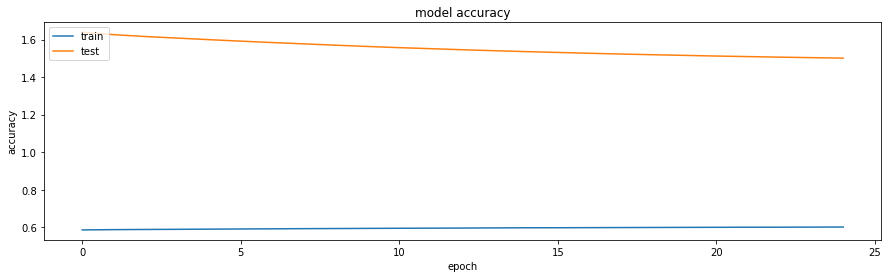

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
model1 = load_model("model3"+standardization+optimizer+".h5")

## Model 2

In [ ]:
model2 = Sequential()


model2.add(Dense(units=256, activation='relu', input_dim=40))
model2.add(Dense(units=256, activation='relu'))
model2.add(Dense(units=256, activation='relu'))
model2.add(Dense(units=256, activation='relu'))
model2.add(Dense(len(stateList), activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [ ]:
history = model2.fit(trainFinal[0], trainFinal[1], epochs=60, batch_size=100)
model2.save("model2"+standardization+optimizer+".h5")

## Model 3

In [ ]:
model3 = Sequential()


model3.add(Dense(units=256, activation='relu', input_dim=91))
model3.add(Dense(units=256, activation='relu'))
model3.add(Dense(units=256, activation='relu'))
model3.add(Dense(units=256, activation='relu'))
model3.add(Dense(len(stateList), activation='softmax'))


filepath = "model3"+standardization+optimizer+".h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model3.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [ ]:

history = model3.fit(trainFinal[0], trainFinal[1], epochs=50, batch_size=1000,  callbacks = callbacks_list)
model3.save("model3"+standardization+optimizer+".h5")

In [ ]:
model3 = load_model("model3"+standardization+optimizer+".h5")

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'loss'], loc='upper left')
plt.show()

### train

## Model 4

In [14]:
model4 = Sequential()


model4.add(Dense(units=256, activation='relu', input_dim=40*7))
model4.add(Dense(units=256, activation='relu'))
model4.add(Dense(units=256, activation='relu'))
model4.add(Dense(units=256, activation='relu'))
model4.add(Dense(len(stateList), activation='softmax'))

filepath = "model3"+standardization+optimizer+".h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model4.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [15]:
history = model4.fit(trainFinal[0], trainFinal[1], epochs=50, batch_size=1000,  callbacks = callbacks_list)
model4.save("model4"+standardization+optimizer+".h5")


Epoch 1/50
1526682/1526682 [==============================] - 22s 14us/step - loss: 1.5188 - accuracy: 0.6172

Epoch 00001: loss improved from inf to 1.51879, saving model to model3wholesdg_0.1_0.1.h5
Epoch 2/50
1526682/1526682 [==============================] - 23s 15us/step - loss: 1.4117 - accuracy: 0.6355

Epoch 00002: loss improved from 1.51879 to 1.41174, saving model to model3wholesdg_0.1_0.1.h5
Epoch 3/50
1526682/1526682 [==============================] - 24s 16us/step - loss: 1.3794 - accuracy: 0.6412

Epoch 00003: loss improved from 1.41174 to 1.37941, saving model to model3wholesdg_0.1_0.1.h5
Epoch 4/50
1526682/1526682 [==============================] - 24s 16us/step - loss: 1.3598 - accuracy: 0.6445

Epoch 00004: loss improved from 1.37941 to 1.35978, saving model to model3wholesdg_0.1_0.1.h5
Epoch 5/50
1526682/1526682 [==============================] - 25s 16us/step - loss: 1.3433 - accuracy: 0.6470

Epoch 00005: loss improved from 1.35978 to 1.34329, saving model to mode

1526682/1526682 [==============================] - 24s 16us/step - loss: 1.1590 - accuracy: 0.6802

Epoch 00040: loss improved from 1.16085 to 1.15904, saving model to model3wholesdg_0.1_0.1.h5
Epoch 41/50
1526682/1526682 [==============================] - 25s 17us/step - loss: 1.1567 - accuracy: 0.6808

Epoch 00041: loss improved from 1.15904 to 1.15675, saving model to model3wholesdg_0.1_0.1.h5
Epoch 42/50
1526682/1526682 [==============================] - 26s 17us/step - loss: 1.1555 - accuracy: 0.6809

Epoch 00042: loss improved from 1.15675 to 1.15547, saving model to model3wholesdg_0.1_0.1.h5
Epoch 43/50
1526682/1526682 [==============================] - 28s 18us/step - loss: 1.1556 - accuracy: 0.6811

Epoch 00043: loss did not improve from 1.15547
Epoch 44/50
1526682/1526682 [==============================] - 24s 16us/step - loss: 1.1531 - accuracy: 0.6813

Epoch 00044: loss improved from 1.15547 to 1.15311, saving model to model3wholesdg_0.1_0.1.h5
Epoch 45/50
1526682/1526682 [

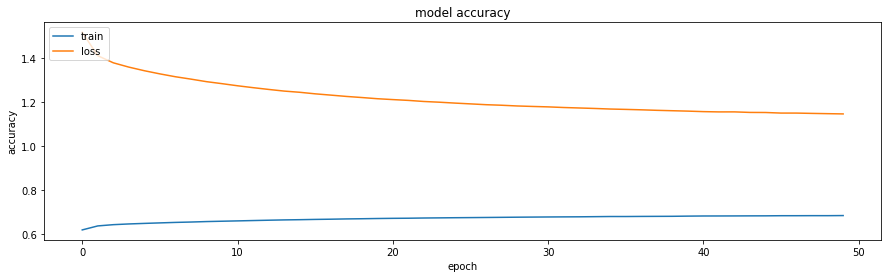

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'loss'], loc='upper left')
plt.show()

## Model custom

# Test

(100,)
[31 32 42 42 42 42 15 15 15 15 15 15 15 15 15 16 17  6  7  8 52 53 54 36
 37 38 18 19 20 24 25 26 36 37 38 42 42 42 42 42 42 42 12 13 14 43 44 45
 58 59 60 21 22 23 33 34 35 30 31 32 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39]


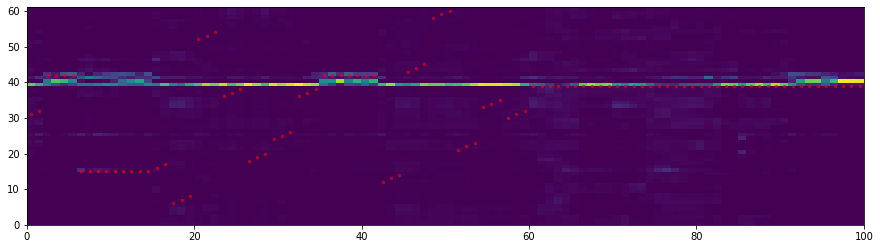

In [65]:
modelTest = model1# model 1-5
samplesStart = 500
numberOfSamples = 100
predictions = modelTest.predict(testFinal[0][samplesStart:samplesStart+numberOfSamples], use_multiprocessing=True)

plt.pcolormesh(predictions.T)
print(np.arange(0,numberOfSamples).shape)
print(np.argmax(testFinal[1][samplesStart:samplesStart+numberOfSamples], axis = 1))
plt.scatter(np.arange(0+0.5, numberOfSamples+0.5), np.argmax(testFinal[1][samplesStart:samplesStart+numberOfSamples], axis = 1), c = "r",s=6, alpha=0.5)
plt.show()

## Detailed Evaluation

In [66]:
score, acc = modelTest.evaluate(x=testFinal[0], y=testFinal[1])
print('Test score:', score)
print('Test accuracy:', acc)

1526682/1526682 [==============================] - 39s 26us/step
Test score: 1.740115066778378
Test accuracy: 0.5806618332862854


## frame by frame

In [ ]:
predictions = modelTest.predict(testFinal[0], use_multiprocessing=True)
predictionMax = np.argmax(predictions, axis=1)
testLabels = np.argmax(testFinal[1], axis=1)

In [ ]:
equal = np.sum(predictionMax == testLabels)

print("Frame by frame accuracy is: ", equal/testFinal[0].shape[0])

## frame by frame merged

In [ ]:
predictions = modelTest.predict(testFinal[0], use_multiprocessing=True)
predictionMax = np.argmax(predictions, axis=1)
testLabels = np.argmax(testFinal[1], axis=1)

In [ ]:
correct = 0
for i in range(predictionMax.shape[0]):
    #print(stateList[predictionMax[i]].split("_")[0])
    if stateList[predictionMax[i]].split("_")[0] == stateList[testLabels[i]].split("_")[0]:
        correct += 1
print("Frame by frame merged accuracy is: ", correct/testFinal[0].shape[0])

## edit distance

In [ ]:
predictions = modelTest.predict(testFinal[0], use_multiprocessing=True)
predictionMax = np.argmax(predictions, axis=1)
testLabels = np.argmax(testFinal[1], axis=1)
print(testLabels.shape)
print(predictionMax.shape)

In [ ]:
distances = np.array([])
stepsize = 200000
for k in range(0, testLabels.shape[0], stepsize):
    print(k,"/",testLabels.shape[0])
    pathPredict = [stateList[predictionMax[k]]]
    for i in range(k, k+stepsize):
        #print(stateList[predictionMax[i]])
        if i < predictionMax.shape[0] and stateList[predictionMax[i]] != pathPredict[-1]:
            #print(stateList[predictionMax[i]])
            pathPredict.append(stateList[predictionMax[i]])

    pathReal = [stateList[testLabels[0]]]
    for i in range(k, k+stepsize):
        if i < testFinal[1].shape[0] and stateList[testLabels[i]] != pathReal[-1]:
            pathReal.append(stateList[testLabels[i]])
            #print(len(pathReal))
    #print("calculate edit dist")
    time.sleep(2)
    print(len(pathPredict), " - ", len(pathReal))
    dist = editdistance.eval(pathPredict, pathReal)
    print("Frame by fram edit distance normalized in step = ", dist/(len(pathReal)+len(pathPredict)))
    distances = np.append(distances, dist/(len(pathReal)+len(pathPredict)))

print("average edit distance:", distances.mean())

## edit distance classes

In [ ]:
predictions = modelTest.predict(testFinal[0], use_multiprocessing=True)
predictionMax = np.argmax(predictions, axis=1)
testLabels = np.argmax(testFinal[1], axis=1)

In [ ]:
distances = np.array([])
stepsize = 400000
for k in range(0, testLabels.shape[0], stepsize):
    print(k,"/",testLabels.shape[0])
    pathPredict = [stateList[predictionMax[k]].split("_")[k] ]
    for i in range(k, k+stepsize):
        #print(stateList[predictionMax[i]])
        if i < predictionMax.shape[0] and stateList[predictionMax[i]].split("_")[0] != pathPredict[-1]:
            #print(stateList[predictionMax[i]])
            pathPredict.append(stateList[predictionMax[i]].split("_")[0] )

    pathReal = [stateList[testLabels[0]].split("_")[k] ]
    for i in range(k, k+stepsize):
        if i < testFinal[1].shape[0] and stateList[testLabels[i]].split("_")[0] != pathReal[-1]:
            pathReal.append(stateList[testLabels[i]].split("_")[0])
            #print(len(pathReal))
    #print("calculate edit dist")
    time.sleep(2)
    print(len(pathPredict), " - ", len(pathReal))
    print(pathPredict[:20], " - ", pathReal[:20])
    
    dist = editdistance.eval(pathPredict, pathReal)
    print("Frame by fram edit distance normalized in step = ", dist/(len(pathReal)+len(pathPredict)))
    distances = np.append(distances, dist/(len(pathReal)+len(pathPredict)))

print("average edit distance:", distances.mean())

In [ ]:
#old too much RAM


pathPredict = [stateList[predictionMax[0]]]
for i in range(1, predictionMax.shape[0]):
    if stateList[predictionMax[i]].split("_")[0] != pathPredict[-1]:
        pathPredict.append(stateList[predictionMax[i]].split("_")[0] )
        
pathReal = [stateList[np.argmax(testFinal[1][0])]]
for i in range(1, testFinal[1].shape[0]):
    #print(stateList[testLabels[i]])
    if stateList[testLabels[i]].split("_")[0] != pathReal[-1]:
        pathReal.append(stateList[testLabels[i]].split("_")[0])

print(len(pathPredict), " - ", len(pathReal))

#dist = editdistance.eval(pathPredict, pathReal)
#print("Frame by fram edit distance normalized", dist/(len(pathReal)+len(pathPredict)))